In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import blob_log, blob_dog, hog
from skimage.color import rgb2gray
from skimage import io
from tensorflow.keras.datasets import mnist
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
from PIL import Image, ImageEnhance

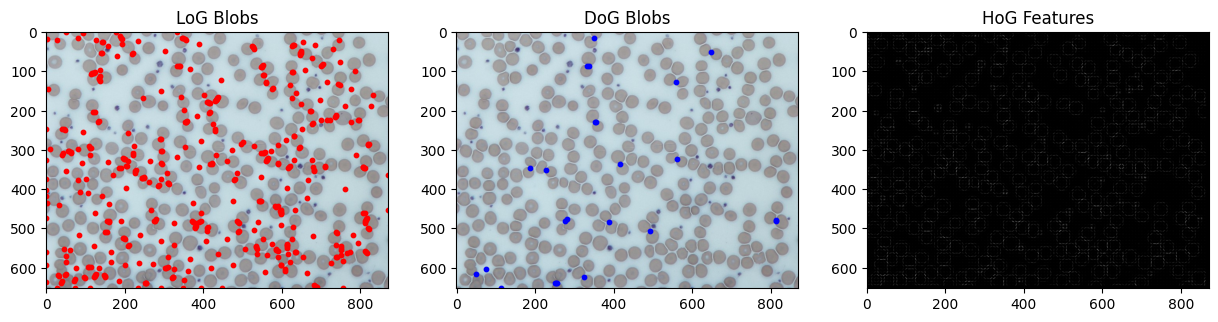

In [ ]:
image = io.imread("/content/Blob.jpg") 
gray_image = rgb2gray(image)

blobs_log = blob_log(gray_image, max_sigma=30, num_sigma=10, threshold=0.1)

blobs_dog = blob_dog(gray_image, max_sigma=30, threshold=0.1)

hog_features, hog_image = hog(gray_image, visualize=True)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(image)
axes[0].scatter(blobs_log[:, 1], blobs_log[:, 0], c='red', s=10)
axes[0].set_title("LoG Blobs")
axes[1].imshow(image)
axes[1].scatter(blobs_dog[:, 1], blobs_dog[:, 0], c='blue', s=10)
axes[1].set_title("DoG Blobs")
axes[2].imshow(hog_image, cmap='gray')  # Display HoG image
axes[2].set_title("HoG Features")
plt.show()


In [ ]:
def enhance_image(image_path):
    image = Image.open(image_path)

    enhancer = ImageEnhance.Brightness(image)
    bright_image = enhancer.enhance(1.5)
    enhancer = ImageEnhance.Contrast(image)
    contrast_image = enhancer.enhance(1.5)

    enhancer = ImageEnhance.Sharpness(image)
    sharp_image = enhancer.enhance(2.0)

    cv_image = np.array(image)
    denoised_image = cv2.GaussianBlur(cv_image, (5, 5), 0)

    return bright_image, contrast_image, sharp_image, denoised_image

bright_img, contrast_img, sharp_img, denoise_img = enhance_image("/content/Satellite.png")


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.fc = nn.Linear(16 * 28 * 28, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

model = ResNet()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

# Training Loop
for epoch in range(3):  # Training for 3 epochs
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize

class PrototypicalNetwork(nn.Module):
    def __init__(self, input_dim=784):
        super(PrototypicalNetwork, self).__init__()
        self.fc = nn.Linear(input_dim, 128)

    def forward(self, x):
        return self.fc(x)

proto_model = PrototypicalNetwork()

class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.conv = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
        self.fc = nn.Linear(64 * 28 * 28, 128)

    def forward(self, x):
        x = torch.relu(self.conv(x))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

siamese_model = SiameseNetwork()

# Evaluation
print("Meta-Learning models initialized successfully")


100%|██████████| 9.91M/9.91M [00:01<00:00, 5.41MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 159kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.51MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 3.42MB/s]


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Meta-Learning models initialized successfully
